In [1]:
import tarfile
tar = tarfile.open("/content/drive/My Drive/task_assignment/internship_data.tar.gz", "r") #разархивируем данные
tar.extractall()

In [2]:
!pip install split-folders #используется далее для разбиения данных на тренировочный и валидационный наборы

In [3]:
import splitfolders

In [4]:
splitfolders.ratio("internship_data", output = "split", seed = 42, ratio=(.8, .2), group_prefix = None) #разбиваем данные

Copying files: 100002 files [00:49, 2040.05 files/s]


In [5]:
#импортируем все необходимые модули
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [6]:
data_transforms = { #предварительная обработка картинок
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), #преобразовывем в torch images
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
dir = 'split'
#загружаем и перемешиваем
dataset = {x: datasets.ImageFolder(os.path.join(dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloader = {x: torch.utils.data.DataLoader(dataset[x], batch_size = 64, shuffle = True) for x in ['train', 'val']}
sizes = {x: len(dataset[x]) for x in ['train', 'val']} 
class_names = dataset['train'].classes #в переменную class_names помещаем названия классов
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #при наличии возможности используем gpu

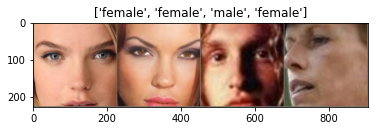

In [7]:
#создадим еще один dataloader с batch_size = 4, чтобы в следующей функции визуализировать 4 картинки
loader = {x: torch.utils.data.DataLoader(dataset['train'], batch_size = 4, shuffle = True) for x in ['train', 'val']}
def viz(images, title): #функция для визуализации нескольких картинок
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean #из формулы x = (x-E)/σ
    plt.imshow(images)
    plt.title(title)
input, classes = next(iter(loader['train']))
images = torchvision.utils.make_grid(input)

viz(images, title = [class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs): #функция для тренировки модели
    best_model = copy.deepcopy(model.state_dict()) #будет храниться модель с наибольшей точностью
    best_acc = 0.0 #переменная, в которой будет храниться наибольшая точность

    for epoch in range(num_epochs): #проходимся по всем шагам
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #для вывода шага в виде, например, 1/10 
        print('-' * 10) #просто для наглядного разделения номера шага и полученных ошибок и acc
        for stage in ['train', 'val']: #в каждом шаге два этапа: обучения и проверки
            if stage == 'train':
                model.train()  #если стадия обучения, то устанавливаем модель в "режим" тренировки
            if stage == 'val':
                model.eval()   #если стадия проверки, то устанавливаем модель в "режим" оценки
            current_loss = 0.0 #переменная, необходимая для подсчета потери на каждом шаге
            current_corrects = 0 #переменная, необходимая для подсчета точности на каждом шаге

            for inputs, labels in dataloader[stage]: #проходимся по данным
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() #обнуляем градиенты
                with torch.set_grad_enabled(stage == 'train'): 
                    out = model(inputs) 
                    _, preds = torch.max(out, 1) #сохраняем в preds предсказанные метки
                    loss = criterion(out, labels) 
                    if stage == 'train': 
                        loss.backward() #делаем backward propagation
                        optimizer.step() #обновляем параметры 
                current_loss += loss.item() * inputs.size(0) #обновляем текущие потери
                current_corrects += torch.sum(preds == labels.data) #обновляем количество правильных ответов
                #сравнивая предсказанные значения и известные метки
            if stage == 'train':
                scheduler.step() #меняем learning rate

            epoch_loss = current_loss / sizes[stage] #считаем ошибку на каждом шаге
            epoch_acc = current_corrects.double() / sizes[stage] #считаем acc путем деления количества 
            #правильных ответов на общее число

            print('{} loss: {:.4f} acc: {:.4f}'.format(stage, epoch_loss, epoch_acc)) #выводим ошибку и точность на каждом шаге
            if stage == 'val' and epoch_acc > best_acc: #обновляем лучшую точность и модель
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    print('Best val accuracy: {:4f}'.format(best_acc)) #выводим на экран лучшую точность
    model.load_state_dict(best_model) #загружаем веса модели, обеспечившей лучший из результатов
    return model

In [9]:
model_50 = models.resnet50(pretrained = True) #загружаем модель resnet50
num_ft = model_50.fc.in_features #получаем число параметров, входящих в последний слой, чтобы изменить его
model_50.fc = nn.Linear(num_ft, 2) #размер выходного слоя устанавливаем равным количеству классов
model_50 = model_50.to(device)
criterion = nn.CrossEntropyLoss() #задаём функцию потерь
optimizer = optim.SGD(model_50.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0001) #задаём алгоритм оптимизации
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1) #каждые 5 шагов будем уменьшать learning rate с коэффициентом 0.1

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [10]:
model_50 = train_model(model_50, criterion, optimizer, scheduler, num_epochs = 7) #тренируем модель, делая 7 шагов оптимизации

Epoch 0/6
----------
train loss: 0.0992 acc: 0.9617
val loss: 0.0649 acc: 0.9767
Epoch 1/6
----------
train loss: 0.0481 acc: 0.9824
val loss: 0.0659 acc: 0.9764
Epoch 2/6
----------
train loss: 0.0319 acc: 0.9888
val loss: 0.0648 acc: 0.9789
Epoch 3/6
----------
train loss: 0.0228 acc: 0.9915
val loss: 0.0740 acc: 0.9760
Epoch 4/6
----------
train loss: 0.0177 acc: 0.9932
val loss: 0.0720 acc: 0.9786
Epoch 5/6
----------
train loss: 0.0058 acc: 0.9982
val loss: 0.0661 acc: 0.9822
Epoch 6/6
----------
train loss: 0.0018 acc: 0.9997
val loss: 0.0703 acc: 0.9827
Best val accuracy: 0.982652


In [11]:
torch.save(model_50, 'model_resnet50_7_steps.pth') #сохраняем натренированную модель